# Data Science for Good: City of Los Angeles

In [1]:
# Import python packages
import os, sys
import pandas as pd,numpy as np
import re
import spacy
from os import walk
import shutil
from shutil import copytree, ignore_patterns
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import xml.etree.cElementTree as ET
from collections import OrderedDict
import json
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
from spacy.util import minibatch, compounding
from spacy.matcher import Matcher
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import calendar
from sklearn.feature_extraction.text import CountVectorizer
from itertools import takewhile, tee
import itertools
import nltk, string
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.cluster.util import cosine_distance
import networkx as nx
from PIL import Image,ImageFilter 
from IPython.display import display, HTML, Javascript

%matplotlib inline

**Master configurations**

In [2]:
bulletin_dir = "../input/data-science-for-good-city-of-los-angeles/cityofla/CityofLA/Job Bulletins"
additional_data_dir = '../input/data-science-for-good-city-of-los-angeles/cityofla/CityofLA/Additional data'
STOP_WORDS = stopwords.words('english')
TREE_ID = 1 #Used to plot interactive graphs

job_titles = pd.read_csv(additional_data_dir+'/job_titles.csv', header=None)
job_class_df = pd.read_csv('../input/dsfg-cityofla-analysis-and-solution/job_class_submission.csv')
data_dictionary = pd.read_csv('../input/dsfg-cityofla-analysis-and-solution/data_dictionary_submission.csv')

job_class_df.fillna('', inplace=True)

[Back to main kernel](https://www.kaggle.com/tyagit3/dsfg-cityofla-analysis-and-solution).

<h1><b>Promotional Paths</b></h1>

This is an attempt for better visualization of different promotional paths available for a particular job title.

**Promotional paths are displayed here as an interactive graph**
- Each node represents a job title
- Edge is the connection between two job titles
- Direction of the edge shows the next level job title
- Clicking on a node will allow it to expand and display next level promotion paths, if available

In order to check available promotions and visualise different paths for a job title, I've tried to create a sample application. Example runs are shown below.

In [3]:
def createEdges (job_class_df):
    edge_cols = ['JOB_CLASS_TITLE','EXP_JOB_CLASS_TITLE','EXPERIENCE_LENGTH','EXPERIENCE_LEN_UNIT']

    df_edges = job_class_df[edge_cols]

    #EXP_JOB_CLASS_TITLE consists of job classes separated with ',' (e.g. SYSTEMS ANALYST, MANAGEMENT ANALYST)
    #Spliting these values and creating rows for each job class
    s = df_edges["EXP_JOB_CLASS_TITLE"].str.split(',', expand=True).stack()
    i = s.index.get_level_values(0)
    df_edges = df_edges.loc[i].copy()
    df_edges["EXP_JOB_CLASS_TITLE"] = s.values

    df_edges['EXP_JOB_CLASS_TITLE'] = df_edges['EXP_JOB_CLASS_TITLE'].apply(lambda x: x.strip())

    df_edges = pd.DataFrame(df_edges.groupby(edge_cols).size().reset_index(name='Freq'))
    df_edges.drop(columns='Freq', inplace=True)

    #remove exp_job_class_title if it is same as job_class_title
    df_edges.loc[df_edges['JOB_CLASS_TITLE']==df_edges['EXP_JOB_CLASS_TITLE'],'EXP_JOB_CLASS_TITLE']=''

    #To find implicit links
    #For job classes like 'Senior Systems Analyst' - junior level job class will be like 'Systems Analyst', if the title exists
    #Find senior job_class that doesn't have junior level exp_job_class_title 
    job_without_juniors = []
    for job_class in df_edges['JOB_CLASS_TITLE'].unique():
        if job_class.startswith('SENIOR'):
            exist = False
            junior_level = job_class.replace('SENIOR','').strip()
            for exp_job in df_edges[df_edges['JOB_CLASS_TITLE']==job_class]['EXP_JOB_CLASS_TITLE']:
                if exp_job.strip()==junior_level:
                    exist = True
                    break
            if not exist:
                #add only those titles that are actually job_titles
                if junior_level in map(str.strip,job_titles[0].values):
                    job_without_juniors.append([job_class,junior_level,'',''])

    df_edges = df_edges.append(pd.DataFrame(job_without_juniors,
                                           columns = edge_cols), ignore_index=True)

    #df_edges.head()
    return df_edges

def getLowerJobEdges(job_title, data):
    """Lower edges or the job titles that can be promoted to job_title.
    
    Parameters
    ----------
    job_title : str
        job class title for which lower job classes are to be searched in data
    data : DataFrame
        dataframe used to search lower job classes
    
    Returns
    -------
    list : [tuple,str]
        tuple - edge tuple (source, target)
        str - edge label
    """
    
    result = []
    for index,e in data.iterrows():
        if e['JOB_CLASS_TITLE'] == job_title and e['EXP_JOB_CLASS_TITLE']!='':
            result.append([(e['EXP_JOB_CLASS_TITLE'],e['JOB_CLASS_TITLE']),
                          str(e['EXPERIENCE_LENGTH'])+' '+e['EXPERIENCE_LEN_UNIT']])
            result.extend(getLowerJobEdges(e['EXP_JOB_CLASS_TITLE'], data))
    return result

def getUpperJobEdges(job_title, data):
    """Upper edges or the job titles that a job_title can be promoted to.
    
    Parameters
    ----------
    job_title : str
        job class title for which upper job classes are to be searched in data
    data : DataFrame
        dataframe used to search upper job classes
    
    Returns
    -------
    list : [tuple,str]
        tuple - edge tuple (source, target)
        str - edge label
    """
    
    result = []
    for index,e in data.iterrows():
        if e['EXP_JOB_CLASS_TITLE'] == job_title:
            result.append([(e['EXP_JOB_CLASS_TITLE'],e['JOB_CLASS_TITLE']),
                          str(e['EXPERIENCE_LENGTH'])+' '+e['EXPERIENCE_LEN_UNIT']])
            result.extend(getUpperJobEdges(e['JOB_CLASS_TITLE'], data))
    return result

def getEdges(job_title, data):
    """Edges or job titles that a job_title can be promoted to/from.
    
    Parameters
    ----------
    job_title : str
        job title to search for edges
    data : DataFrame
        dataframe used to search upper job classes
    
    Returns
    -------
    list : [tuple,str]
        tuple - edge tuple (source, target)
        str - edge label
    """
    
    edges = []
    edges = getLowerJobEdges(job_title, data)
    edges.extend(getUpperJobEdges(job_title, data))
    return edges

def plotGraph(G):
    """Plots a networkx graph
    
    Parameters
    ----------
    G : networkx Graph
    """
    
    plt.figure(figsize=(12, 12)) 
    plt.axis('off')
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos, with_labels=True, 
                    node_color='blue', font_size=8, node_size=10000, width = 2)
    
    #Uncomment below to draw edge labels
    #nx.draw_networkx_edge_labels(G, label_pos=.5, pos=pos)
    
    plt.show()

def getPromotionalPaths(df_edges, job_class_df, job_title, candidateDataDf=pd.DataFrame):    
    if 'JOB_CLASS_TITLE' in candidateDataDf.columns:
        #only first row will be considered and searched for promotional paths
        job_title = candidateDataDf['JOB_CLASS_TITLE'].iloc[0]
    if job_title == '':
        print('No job title assigned.')
        return
    
    job_nodes = job_class_df[job_class_df['JOB_CLASS_TITLE']==job_title][['JOB_CLASS_TITLE',
                                                                          'EXP_JOB_CLASS_TITLE']]
    job_node_names = [n[0] for index,n in job_nodes.iterrows()]
    job_edges = getEdges(job_title, df_edges)
    
    eligibilityCheckFrames = {}
    for edge in job_edges:
        #print(edge)
        if edge[0][0] == job_title:
            eligibilityCheckFrames[edge[0][1]] = checkEligibility(job_title=edge[0][1], job_class_df = job_class_df, candidateDataDf=candidateDataDf)
    
    job_edge_names = [e[0] for e in job_edges]
    
    #set edge labels
    experience_dict={}
    for edge in job_edges:
        experience_dict[edge[0]] = edge[1]

    #networkx directed graph for promotion path visuals
    G = nx.DiGraph()
    G.add_nodes_from(job_node_names)
    G.add_edges_from(job_edge_names)
    nx.set_edge_attributes(G, experience_dict, 'Experience')

    result = {
              "job_title" : job_title,
              "prom_messages" : eligibilityCheckFrames,
              "interact_graph" : showInteractivePromotionalPaths(df_edges, job_title),
              "static_graph" : G
            }
    return result

def viewOutput(response):
    display(HTML("<br>"))
    display(HTML("<center><h2><b>Promotions availability search output for : " + response["job_title"].title() + "</b></h2></center>"))
    #display(HTML(response["prom_messages"]))
    eligibilityCheckFrames = response["prom_messages"]
    if len(eligibilityCheckFrames)>0:
        eligibilityCheckFrames = OrderedDict(sorted(eligibilityCheckFrames.items(), key=lambda kv: len(kv[1])))
        
        for key in eligibilityCheckFrames.keys():
            if len(eligibilityCheckFrames[key])==0:
                display(HTML("<b>Candidate is eligible for promotion for : <u>" + key.title() + "</u></b>"))
            else:
                display(HTML("To be eligible for promotion for : <b>" + key.title() + "</b>, below requirements needs to be fulfilled."))
                df = eligibilityCheckFrames[key]
                df.index = np.arange(1,len(df)+1)
                df['EXPERIENCE_LENGTH'] = df['EXPERIENCE_LENGTH'].fillna('0')
                display(df)
        display(HTML("<br><br><b>Note: </b><i>Only experience and license details are matched for the above results. Please check with the concerned department for other requirement details.</i>"))
        #display(HTML(plotGraph(response["static_graph"])))
        
        display(HTML(response["interact_graph"]))
    else:
        display(HTML("<b>Current criteria doesn't match for any job class level promotion</b>"))
        display(HTML("<h4>Paths connected with " + response["job_title"].title() + " job title are shown below.</h4>"))
        display(HTML(plotGraph(response["static_graph"])))
    
def showPromotionalPaths(df_edges, job_class_df, job_title, candidateDataDf=pd.DataFrame):
    """Displays eligible/proposed promotions. Future promotion paths are also displayed as a directed graph.
    
    Parameters
    ----------
    candidateDatadf : DataFrame
        Dataframe consisting of data for a candidate to be searched for available promotions. Only first row will be considered.
    df_edges : DataFrame
        Dataframe consisting of all available data edges from all job classes
    """
    
    if 'JOB_CLASS_TITLE' in candidateDataDf.columns:
        #only first row will be considered and searched for promotional paths
        job_title = candidateDataDf['JOB_CLASS_TITLE'].iloc[0]
    if job_title == '':
        print('No job title assigned.')
        return
    
    job_nodes = job_class_df[job_class_df['JOB_CLASS_TITLE']==job_title][['JOB_CLASS_TITLE',
                                                                          'EXP_JOB_CLASS_TITLE']]
    job_node_names = [n[0] for index,n in job_nodes.iterrows()]
    job_edges = getEdges(job_title, df_edges)
    
    for edge in job_edges:
        if edge[0][0] == job_title:
            checkEligibility(job_title=edge[0][1], job_class_df = job_class_df, candidateDataDf=candidateDataDf) #check and print eligiblity for explicit promotions
    
    job_edge_names = [e[0] for e in job_edges]
    
    #set edge labels
    experience_dict={}
    for edge in job_edges:
        experience_dict[edge[0]] = edge[1]

    #networkx directed graph for promotion path visuals
    G = nx.DiGraph()
    G.add_nodes_from(job_node_names)
    G.add_edges_from(job_edge_names)
    nx.set_edge_attributes(G, experience_dict, 'Experience')

    #print(nx.info(G))
    plotGraph(G)

class Experience:
    """A class to represent experience details
    
    Attributes
    ----------
    expLength : float
        experience length
    expLengthUnit : str
        unit for experience length (e.g. year/month/hour)
    fullTimePartTime : str
        type of experience (FULL_TIME/PART_TIME)
    paidVolunteer : str
        type of experience (PAID/VOLUNTEER)
    experience : str
        Represents the experience text by concatenating other attributes
    errMsg : str
        Represents the errors/mismatch occured while comparing two experiences. Blank if matched.
    
    Methods
    -------
    compare(objCandidateExperience)
        Compares self with another experience object(i.e. objCandidateExperience) and returns errMsg accordingly
    getExperience
        Outputs a string representing the experience text
    getErrMsg
        Outputs a message to be displayed in case of comparison mismatch
    """
    
    def __init__(self, dfJobClassRow):
        """
        
        Parameters
        ----------
        dfJobClassRow : Series
            Row of Job Class dataframe, containing experience related columns
        """
        if dfJobClassRow['EXPERIENCE_LENGTH']=='':
            self.expLength = 0
        else:
            self.expLength = float(dfJobClassRow['EXPERIENCE_LENGTH'])
        
        self.expLengthUnit = dfJobClassRow['EXPERIENCE_LEN_UNIT']
        self.fullTimePartTime = dfJobClassRow['FULL_TIME_PART_TIME']
        self.paidVolunteer = dfJobClassRow['PAID_VOLUNTEER']
        self.experience = self.getExperience()
        self.errMsg = ''
    
    def compare(self, objCandidateExperience):
        """Compares self with another experience class object
        
        Parameters
        ----------
        objCandidateExperience : Experience
            object for Experience class created for a candidate
        
        Returns
        -------
        errMsg : str
            blank if matched, else mismatched experience requirement string
        """
        
        if self.experience == objCandidateExperience.experience:
            self.errMsg = ''
        else:
            if self.expLength == objCandidateExperience.expLength and self.expLengthUnit == objCandidateExperience.expLengthUnit:
                if self.fullTimePartTime == objCandidateExperience.fullTimePartTime:
                    if objCandidateExperience.paidVolunteer in self.paidVolunteer:
                        self.errMsg = ''
                    else:
                        self.errMsg = self.getErrorMsg()
                else:
                    if objCandidateExperience.fullTimePartTime in self.fullTimePartTime:
                        if objCandidateExperience.paidVolunteer in self.paidVolunteer.contains:
                            self.errMsg = ''
                        else:
                            self.errMsg = self.getErrorMsg()
                    else:
                        self.errMsg = self.getErrorMsg()
            elif self.expLengthUnit == objCandidateExperience.expLengthUnit:
                if self.expLength < objCandidateExperience.expLength:
                    if self.fullTimePartTime == objCandidateExperience.fullTimePartTime:
                        if objCandidateExperience.paidVolunteer in self.paidVolunteer:
                            self.errMsg = ''
                        else:
                            self.errMsg = self.getErrorMsg()
                    else:
                        if objCandidateExperience.fullTimePartTime in self.fullTimePartTime:
                            if objCandidateExperience.paidVolunteer in self.paidVolunteer.contains:
                                self.errMsg = ''
                            else:
                                self.errMsg = self.getErrorMsg()
                        else:
                            self.errMsg = self.getErrorMsg()
                else:
                    self.errMsg = self.getErrorMsg()
            else:
                self.errMsg = self.getErrorMsg()
        #print(self.experience, objCandidateExperience.experience)
        return self.errMsg
    
    def getExperience(self):
        """Outputs a string representing the experience text
        
        Returns
        -------
        str - string representing the experience text
        """
        
        return ' '.join([str(float(self.expLength) if self.expLength != '' else self.expLength),
                         self.expLengthUnit,
                         self.fullTimePartTime.replace('|','/'),
                         self.paidVolunteer.replace('|','/')])
    
    def getErrorMsg(self):
        """Outputs a message to be displayed in case of comparison mismatch"""
        
        return self.experience + ' experience is required for this job class.'

class License:
    """A class to represent license details
    
    Attributes
    ----------
    driverLicReq : str
        whether driver's license is required for a job class or not. In case of candidate, it should be 'R' if one holds a license
    driverLicType : str
        license types hold by candidate/ license types required for a job class
    additionalLic : str
        additional licenses hold by candidate/ required for a job class
    license : str
        Represents the license text by concatenating other attributes
    errMsg : str
        Represents the errors/mismatch occured while comparing two licenses. Blank if matched.
    
    Methods
    -------
    compare(objCandidateLicense)
        Compares self with another license object(i.e. objCandidateLicense) and returns errMsg accordingly
    getLicense
        Outputs a string representing the license text
    getErrMsg
        Outputs a message to be displayed in case of comparison mismatch
    """
    
    def __init__(self, dfJobClassRow):
        """
        
        Parameters
        ----------
        dfJobClassRow : Series
            Row of Job Class dataframe, containing license related columns
        """
        
        if 'DRIVERS_LICENSE_REQ' in dfJobClassRow:
            self.driverLicReq = dfJobClassRow['DRIVERS_LICENSE_REQ']
        else:
            self.driverLicReq = 'R'
        self.driverLicType = dfJobClassRow['DRIV_LIC_TYPE']
        self.additionalLic = dfJobClassRow['ADDTL_LIC']
        self.license = self.getLicense()
        self.errMsg = ''
    
    def compare(self, objCandidateLicense):
        """Compares self with another license class object
        
        If DRIVERS_LICENSE_REQ is 'P', then this will consider it as a match
        Additional licenses are not compared in this method.
        
        Parameters
        ----------
        objCandidateLicense : License
            object for License class created for a candidate
        
        Returns
        -------
        errMsg : str
            blank if matched, else mismatched license requirement string
        """
        
        if self.driverLicReq == 'P' or self.driverLicReq == '':
            self.errMsg = ''
        else:
            if self.driverLicType == '' and objCandidateLicense.driverLicReq == 'R':
                self.errMsg = ''            
            elif objCandidateLicense.driverLicType in self.driverLicType:
                self.errMsg = ''
            else:
                self.errMsg = self.getErrorMsg()
        
        return self.errMsg
    
    def getLicense(self):
        """Outputs a string representing the license text
        
        Returns
        -------
        str - string representing the license text
        """
        
        return self.driverLicType
    
    def getErrorMsg(self):
        """Outputs a message to be displayed in case of comparison mismatch"""
        
        if self.driverLicType != '':
            return self.driverLicType + ' license is required for this job class.'
        else:
            return 'A valid California driver\'s license is required for this job class.'

class JobClass:
    """A class to represent job class details
    
    Attributes
    ----------
    jobClassTitle : str
        job class title/ current job class of candidate
    examType : str
        OPEN, INT_DEPT_PROM, DEPT_PROM, OPEN_INT_PROM ('' if not provided)
    selectionCriteria : str
        selection criteria for a job class ('' if not provided)
    requirementSetId : str
        requirement set id ('' if not provided)
    requirementSubSetId : str
        requirement sub set id ('' if not provided)
    experience : Experience
        experience details for job class
    license : License
        license details for job class
    errMsg : str
        Represents the errors/mismatch occured while comparing two licenses. Blank if matched.
    
    Methods
    -------
    compare(candidateJobClass)
        Compares self with another JobClass object(i.e. candidateJobClass) and returns errMsg accordingly
    """
    
    def __init__(self, dfJobClassRow):
        """
        
        Parameters
        ----------
        dfJobClassRow : Series
            Row of Job Class dataframe, containing job class columns
        """
        
        if 'JOB_CLASS_TITLE' in dfJobClassRow:
            self.jobClassTitle = dfJobClassRow['JOB_CLASS_TITLE']
        else:
            self.jobClassTitle = 'CandidateJobClass'
        if 'EXAM_TYPE' in dfJobClassRow:
            self.examType = dfJobClassRow['EXAM_TYPE']
        else:
            self.examType = ''
        if 'SELECTION_CRITERIA' in dfJobClassRow:
            self.selectionCriteria = dfJobClassRow['SELECTION_CRITERIA']
        else:
            self.selectionCriteria = ''
        self.expJobClassTitle = dfJobClassRow['EXP_JOB_CLASS_TITLE']
        if 'REQUIREMENT_SET_ID' in dfJobClassRow:
            self.requirementSetId = dfJobClassRow['REQUIREMENT_SET_ID']
        else:
            self.requirementSetId = ''
        if 'REQUIREMENT_SUBSET_ID' in dfJobClassRow:
            self.requirementSubSetId = dfJobClassRow['REQUIREMENT_SUBSET_ID']
        else:
            self.requirementSubSetId = ''
        self.experience = Experience(dfJobClassRow)
        self.license = License(dfJobClassRow)
        self.errMsg = ''
    
    def compare(self, candidateJobClass):
        """Compares experience, license details of a candidate job class with self
        
        Parameters
        ----------
        candidateJobClass : JobClass
            JobClass object for candidate to be compared
        Returns
        -------
        errMsg : str
            blank if matched, else mismatched requirements string
        """
        
        self.errMsg = self.errMsg + ' ' + self.experience.compare(candidateJobClass.experience)
        self.errMsg = self.errMsg + ' ' + self.license.compare(candidateJobClass.license)
        return self.errMsg.strip()

def checkRequirements(data, candidateJobClass):
    """Matches the requirements of the job class with supplied candidate job class data
    
    Parameters
    ----------
    data : DataFrame
        job class data with the data_dictionary fields (requirements to match to be eligible for the promotion)
    candidateJobClass : JobClass
        candidate data with which the requirements will be matched
    
    Returns
    -------
    list [errMsg, conj]
        a row for each requirement in data
        errMsg - blank if matches the requirements, else contains not matched requirement texts
        conj - conjuction to be checked with other requirements (i.e.or/and)
    """
    
    conj = ''
    result = []

    for index,row in data.iterrows():
        conj = row['REQUIREMENT_CONJ']
        if conj == '':
            conj = 'and'
        
        jobClass = JobClass(row)
        errMsg = jobClass.compare(candidateJobClass)
        result.append([errMsg, conj])
    return result

def matchRequirements(requirementsResult):
    """Applies conjuctions on multiple requirements(checkRequirements result) 
    
    Parameters
    ----------
    requirementsResult : list
        [errMsg, conj]
        errMsg - blank for matched requirements, else contains not matched requirement texts
        conj - conjuction to be checked with other requirements (i.e.or/and)
    
    Returns
    -------
    errMsg, conj
        errMsg - blank if all requirements matched, else ';' separated message for all unmatched requirements
        conj - last conjuction to be matched with other requirements(if any). Will be used if first called for sub-requirements
    """
    
    resultErrList = [] 
    resultRequirementsMatch = False
    conj = ''
    for row in requirementsResult:
        errMsg = row[0]
        conj = row[1]
        currentRequirementsMatch = False
        if len(errMsg)==0:
            currentRequirementsMatch = True
        else:
            resultErrList.append(errMsg)
            currentRequirementsMatch = False
        if conj=='or':
            if not resultRequirementsMatch:
                if currentRequirementsMatch:
                    resultErrList = []
                    resultRequirementsMatch = True
        elif conj=='and':
            if not currentRequirementsMatch:
                resultRequirementsMatch = False
        else:
            resultRequirementsMatch = currentRequirementsMatch
    return ';'.join(resultErrList),conj

def checkEligibility(job_title, job_class_df, candidateDataDf):
    """For a job title, compares all the requirements for all the explicitly mentioned promotions in job class dataframe.
    
    Prints messages based on requirements match/mismatch.
    
    Parameters
    ----------
    job_title : str
        job title of the candidate to be searched and matched with the requirements
    """
    
    job_title = job_title
    single_job_class_df = job_class_df[job_class_df['JOB_CLASS_TITLE'] == job_title]
    single_job_class_df = single_job_class_df.iloc[::-1] #reverse the dataframe
    candidate_job_class = JobClass(candidateDataDf.iloc[0])
    prevRqmntId = ''
    result = []
    i = 0
    for index,row in single_job_class_df.iterrows(): 
        rqmntId = ''
        if row['REQUIREMENT_SUBSET_ID'] != '':
            rqmntId = row['REQUIREMENT_SET_ID']
            if prevRqmntId == '':
                prevRqmntId = rqmntId
                data = single_job_class_df[single_job_class_df['REQUIREMENT_SET_ID'] == rqmntId]
                rqmntChk = checkRequirements(data, candidate_job_class)
                errMsg,conj = matchRequirements(rqmntChk)
                conj = data['REQUIREMENT_CONJ'].iloc[0]
                result.append([errMsg,conj])
            if rqmntId != prevRqmntId:
                prevRqmntId = rqmntId  
                data = single_job_class_df[single_job_class_df['REQUIREMENT_SET_ID'] == rqmntId]
                rqmntChk = checkRequirements(data, candidate_job_class)
                errMsg,conj = matchRequirements(rqmntChk)
                conj = data['REQUIREMENT_CONJ'].iloc[0]
                result.append([errMsg,conj])
        else:
            rqmntId = ''
            data = pd.DataFrame(row).transpose()
            rqmntChk = checkRequirements(data, candidate_job_class)
            errMsg,conj = rqmntChk[0][0],rqmntChk[0][1]
            result.append([errMsg,conj])
    #print(result)
    errMsg,conj = matchRequirements(result)
    resultDataFrame = pd.DataFrame()
    resultColumns = ['EXPERIENCE_LENGTH','EXPERIENCE_LEN_UNIT','FULL_TIME_PART_TIME','PAID_VOLUNTEER','DRIVERS_LICENSE_REQ','DRIV_LIC_TYPE','REQUIREMENT_CONJ']
    msg = ''
    if errMsg.strip() != '':
        resultDataFrame = job_class_df[job_class_df['JOB_CLASS_TITLE']==job_title][resultColumns]
    return resultDataFrame

def getTreeFormattedChildren(df, title):
    if title=='':
        print('No job title provided')
        return
    resultList = []
    result = {}
    result['name'] = str(title.title())
    children = df[df['name']==title]['children'].values
    if len(children)>0:
        for child in children:
            resultList.append(getTreeFormattedChildren(df, child))
        result['children'] = resultList
    else:
        return result
    return result

def getTreeHTML(data, title):
    global TREE_ID
    treeId = str(TREE_ID)
    treeHtml = """
    <!DOCTYPE html>
    <meta charset="utf-8">
    <style>
    .node circle {
      fill: #fff;
      stroke: steelblue;
      stroke-width: 3px;
    }

    .node text { font: 8px sans-serif; }

    .node--internal text {
      text-shadow: 0 1px 0 #fff, 0 -1px 0 #fff, 1px 0 0 #fff, -1px 0 0 #fff;
    }

    .link {
      fill: none;
      stroke: #ccc;
      stroke-width: 2px;
    }
    </style>
    <body>
    <div style="font: 20px sans-serif; color: #42374D"><b>Promotional Paths</b></div>
    <div id="fd"""+treeId+""""></div>
    <div style="font: 16px sans-serif; color: #42374D"><b>Above graph is interactive. Click on nodes to view more detailed paths</b></div>
    <script>
    require.config({
        paths: {
            d3: "https://d3js.org/d3.v4.min"
         }
     });

    require(["d3"], function(d3) {
    var treeData =
      """+json.dumps(getTreeFormattedChildren(data, title))+"""

    // Set the dimensions and margins of the diagram
    var margin = {top: 20, right: 90, bottom: 30, left: 90},
        width = 960 - margin.left - margin.right,
        height = 800 - margin.top - margin.bottom;

    // append the svg object to the body of the page
    // appends a 'group' element to 'svg'
    // moves the 'group' element to the top left margin
    var svg = d3.select("#fd"""+treeId+"""").append("svg")
        .attr("width", width + margin.right + margin.left)
        .attr("height", height + margin.top + margin.bottom)
      .append("g")
        .attr("transform", "translate("
              + margin.left + "," + margin.top + ")");

    var i = 0,
        duration = 750,
        root;

    // declares a tree layout and assigns the size
    var treemap = d3.tree().size([height, width]);

    // Assigns parent, children, height, depth
    root = d3.hierarchy(treeData, function(d) { return d.children; });
    root.x0 = height / 2;
    root.y0 = 0;

    // Collapse after the second level
    root.children.forEach(collapse);

    update(root);

    // Collapse the node and all it's children
    function collapse(d) {
      if(d.children) {
        d._children = d.children
        d._children.forEach(collapse)
        d.children = null
      }
    }

    function update(source) {

      // Assigns the x and y position for the nodes
      var treeData = treemap(root);

      // Compute the new tree layout.
      var nodes = treeData.descendants(),
          links = treeData.descendants().slice(1);

      // Normalize for fixed-depth.
      nodes.forEach(function(d){ d.y = d.depth * 180});

      // ****************** Nodes section ***************************

      // Update the nodes...
      var node = svg.selectAll('g.node')
          .data(nodes, function(d) {return d.id || (d.id = ++i); });
    
      // Enter any new modes at the parent's previous position.
      var nodeEnter = node.enter().append('g')
          .attr('class', 'node')
          .attr("transform", function(d) {
            return "translate(" + source.y0 + "," + source.x0 + ")";
        })
        .on('click', click);

      // Add Circle for the nodes
      nodeEnter.append('circle')
          .attr('class', 'node')
          .attr('r', 1e-6)
          .style("fill", function(d) {
              return d._children ? "lightsteelblue" : "#fff";
          });

      // Add labels for the nodes
      nodeEnter.append('text')
          .attr("dy", ".35em")
          .attr("x", function(d) {
              return d.children || d._children ? -13 : 13;
          })
          .attr("text-anchor", function(d) {
              return d.children || d._children ? "end" : "start";
          })
          .text(function(d) { return d.data.name; });

      // UPDATE
      var nodeUpdate = nodeEnter.merge(node);

      // Transition to the proper position for the node
      nodeUpdate.transition()
        .duration(duration)
        .attr("transform", function(d) { 
            return "translate(" + d.y + "," + d.x + ")";
         });

      // Update the node attributes and style
      nodeUpdate.select('circle.node')
        .attr('r', 10)
        .style("fill", function(d) {
            return d._children ? "lightsteelblue" : "#fff";
        })
        .attr('cursor', 'pointer');


      // Remove any exiting nodes
      var nodeExit = node.exit().transition()
          .duration(duration)
          .attr("transform", function(d) {
              return "translate(" + source.y + "," + source.x + ")";
          })
          .remove();

      // On exit reduce the node circles size to 0
      nodeExit.select('circle')
        .attr('r', 1e-6);

      // On exit reduce the opacity of text labels
      nodeExit.select('text')
        .style('fill-opacity', 1e-6);

      // ****************** links section ***************************

      // Update the links...
      var link = svg.selectAll('path.link')
          .data(links, function(d) { return d.id; });

      // Enter any new links at the parent's previous position.
      var linkEnter = link.enter().insert('path', "g")
          .attr("class", "link")
          .attr('d', function(d){
            var o = {x: source.x0, y: source.y0}
            return diagonal(o, o)
          });

      // UPDATE
      var linkUpdate = linkEnter.merge(link);

      // Transition back to the parent element position
      linkUpdate.transition()
          .duration(duration)
          .attr('d', function(d){ return diagonal(d, d.parent) });

      // Remove any exiting links
      var linkExit = link.exit().transition()
          .duration(duration)
          .attr('d', function(d) {
            var o = {x: source.x, y: source.y}
            return diagonal(o, o)
          })
          .remove();

      // Store the old positions for transition.
      nodes.forEach(function(d){
        d.x0 = d.x;
        d.y0 = d.y;
      });

      // Creates a curved (diagonal) path from parent to the child nodes
      function diagonal(s, d) {

        path = `M ${s.y} ${s.x}
                C ${(s.y + d.y) / 2} ${s.x},
                  ${(s.y + d.y) / 2} ${d.x},
                  ${d.y} ${d.x}`

        return path
      }

      // Toggle children on click.
      function click(d) {
        if (d.children) {
            d._children = d.children;
            d.children = null;
          } else {
            d.children = d._children;
            d._children = null;
          }
        update(d);
      }
    }
    });
    </script>
    </body>
    """
    
    TREE_ID = TREE_ID + 1
    return treeHtml

def showInteractivePromotionalPaths(df_edges, job_title):
    treeEdges = getEdges(data=df_edges, job_title=job_title)
    edges = []
    for edge in treeEdges:
        edges.append((edge[0][0],edge[0][1]))
    
    treeEdges = pd.DataFrame(edges, columns=['name','children'])
    treeEdges = treeEdges.groupby(['name','children']).size().reset_index(name='Freq')
    return getTreeHTML(treeEdges, job_title)

<h1><b>Application</b></h1>
<br>
<div style='background:#ECE3E3;padding:30px;'>
    Check for available promotional paths for a candidate/job_title.
<br>Prints messages for unfulfilled requirement sets for available promotion job titles.
<br><br>
<b>Required configurations to execute</b>:<br>
    <pre>
#import libraries
#set master configurations
data = {'JOB_CLASS_TITLE': 'WATER UTILITY WORKER',
        'EXP_JOB_CLASS_TITLE': 'WATER UTILITY WORKER',
        'EXPERIENCE_LENGTH': '1',
        'EXPERIENCE_LEN_UNIT': 'years',
        'FULL_TIME_PART_TIME': 'FULL_TIME',
        'PAID_VOLUNTEER': 'PAID',
        'DRIVERS_LICENSE_REQ': 'R',
        'DRIV_LIC_TYPE': '',
        'ADDTL_LIC': 'NA'}

#sample candidate job class data
candidate_job_class_df = pd.DataFrame(data=data, index=[0])  
#edges for graph
df_edges = createEdges(job_class_df)
    </pre>
<br>
<b>Command to execute</b>: <br>
    <pre>response = getPromotionalPaths(df_edges, job_class_df, '', candidate_job_class_df)
viewOutput(response)</pre>
<br>
</div>

<hr>
# <b>Example of WATER UTILITY WORKER with 1 years of experience</b>

In [4]:
#Test CandidateJobClass
data = {'JOB_CLASS_TITLE': 'WATER UTILITY WORKER',
        'EXP_JOB_CLASS_TITLE': 'WATER UTILITY WORKER',
        'EXPERIENCE_LENGTH': '1',
        'EXPERIENCE_LEN_UNIT': 'years',
        'FULL_TIME_PART_TIME': 'FULL_TIME',
        'PAID_VOLUNTEER': 'PAID',
        'DRIVERS_LICENSE_REQ': 'R',
        'DRIV_LIC_TYPE': '',
        'ADDTL_LIC': 'NA'}
candidate_job_class_df = pd.DataFrame(data=data, index=[0])
df_edges = createEdges(job_class_df)

response = getPromotionalPaths(df_edges, job_class_df, '', candidate_job_class_df)
viewOutput(response)

,EXPERIENCE_LENGTH,EXPERIENCE_LEN_UNIT,FULL_TIME_PART_TIME,PAID_VOLUNTEER,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,REQUIREMENT_CONJ
1,3.0,years,FULL_TIME,PAID,R,,


,EXPERIENCE_LENGTH,EXPERIENCE_LEN_UNIT,FULL_TIME_PART_TIME,PAID_VOLUNTEER,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,REQUIREMENT_CONJ
1,4.0,years,FULL_TIME,PAID,R,,or
2,4.0,years,FULL_TIME,PAID,R,,


Based on the above results, 3 years experience is required to be eligible for promotion for job class: **Water Service Supervisor**. So let's check the results for a candidate with 3 years of experience.

<hr>
# <b>Example of WATER UTILITY WORKER with 3 years of experience</b>

In [5]:
#Test CandidateJobClass
data = {'JOB_CLASS_TITLE': 'WATER UTILITY WORKER',
        'EXP_JOB_CLASS_TITLE': 'WATER UTILITY WORKER',
        'EXPERIENCE_LENGTH': '3',
        'EXPERIENCE_LEN_UNIT': 'years',
        'FULL_TIME_PART_TIME': 'FULL_TIME',
        'PAID_VOLUNTEER': 'PAID',
        'DRIVERS_LICENSE_REQ': 'R',
        'DRIV_LIC_TYPE': '',
        'ADDTL_LIC': 'NA'}
candidate_job_class_df = pd.DataFrame(data=data, index=[0])
df_edges = createEdges(job_class_df)

response = getPromotionalPaths(df_edges, job_class_df, '', candidate_job_class_df)
viewOutput(response)

,EXPERIENCE_LENGTH,EXPERIENCE_LEN_UNIT,FULL_TIME_PART_TIME,PAID_VOLUNTEER,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,REQUIREMENT_CONJ
1,4.0,years,FULL_TIME,PAID,R,,or
2,4.0,years,FULL_TIME,PAID,R,,


<hr>
# <b>Example of 311 DIRECTOR with 3 years of experience</b>

Below is an example where promotional paths are not found for the job title.
<br><br>In that case, a static graph will be shown wherein all the connected paths to the searched job title, are visible.

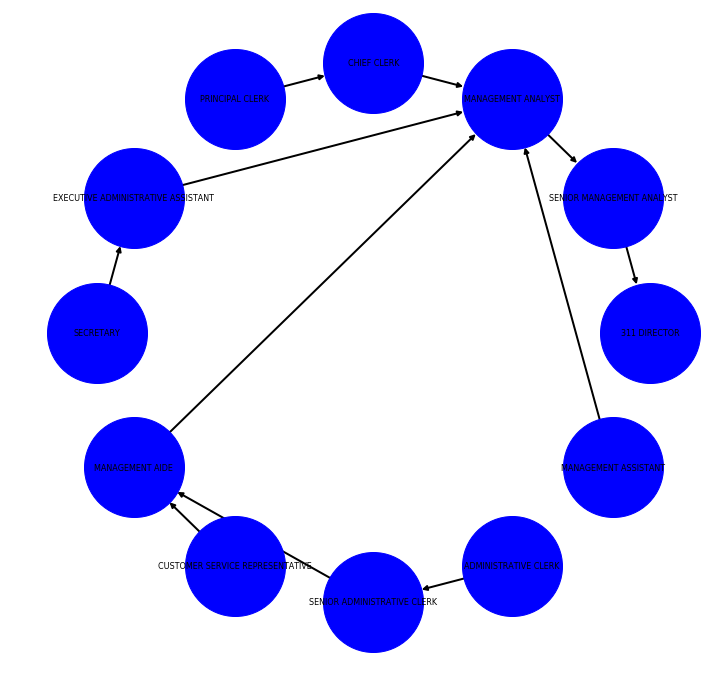

<IPython.core.display.HTML object>

In [6]:
#Test CandidateJobClass
data = {'JOB_CLASS_TITLE': '311 DIRECTOR',
        'EXP_JOB_CLASS_TITLE': '311 DIRECTOR',
        'EXPERIENCE_LENGTH': '3',
        'EXPERIENCE_LEN_UNIT': 'years',
        'FULL_TIME_PART_TIME': 'FULL_TIME',
        'PAID_VOLUNTEER': 'PAID',
        'DRIVERS_LICENSE_REQ': 'R',
        'DRIV_LIC_TYPE': '',
        'ADDTL_LIC': 'NA'}
candidate_job_class_df = pd.DataFrame(data=data, index=[0])
df_edges = createEdges(job_class_df)
response = getPromotionalPaths(df_edges, job_class_df, '', candidate_job_class_df)
viewOutput(response)

Here it can be seen that no edge goes out of the searched job title.

<hr>
# <b>Example of SENIOR PERSONNEL ANALYST with 1 years of experience</b>

In [7]:
#Test CandidateJobClass
data = {'JOB_CLASS_TITLE': 'SENIOR PERSONNEL ANALYST',
        'EXP_JOB_CLASS_TITLE': 'SENIOR PERSONNEL ANALYST',
        'EXPERIENCE_LENGTH': '1',
        'EXPERIENCE_LEN_UNIT': 'years',
        'FULL_TIME_PART_TIME': 'FULL_TIME',
        'PAID_VOLUNTEER': 'PAID',
        'DRIVERS_LICENSE_REQ': 'R',
        'DRIV_LIC_TYPE': '',
        'ADDTL_LIC': 'NA'}
candidate_job_class_df = pd.DataFrame(data=data, index=[0])
df_edges = createEdges(job_class_df)
response = getPromotionalPaths(df_edges, job_class_df, '', candidate_job_class_df)
viewOutput(response)

,EXPERIENCE_LENGTH,EXPERIENCE_LEN_UNIT,FULL_TIME_PART_TIME,PAID_VOLUNTEER,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,REQUIREMENT_CONJ
1,2.0,years,FULL_TIME,PAID,P,,


,EXPERIENCE_LENGTH,EXPERIENCE_LEN_UNIT,FULL_TIME_PART_TIME,PAID_VOLUNTEER,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,REQUIREMENT_CONJ
1,2.0,years,FULL_TIME,PAID,P,,


<hr>
**Features**
1. Provided details of a candidate, the application searches the job_class data for the available job titles to which the candidate can be promoted to.
2. Provided clear data and logics, details can be easily added to the comparison matrices with simple tweaks in the code.
    - If someone follows through the code, below is an explanation on how to add a new comparison detail to the search criteria.
3. Logic takes care of the requirement conjunctions used in the bulletins text.

**Areas of improvement**
1. The comparison only takes experience and licence details into consideration. Provided some master data and clear comparison logics more details can be added to the comparison matrices.

<br><br><br><br>
**Steps to add new comparison detail in search criteria:**
e.g. to add Education details('COURSE_COUNT')
1. Create a new class "Education" with the following signature
<pre>
    class Education:
        def __init__(self, dfJobClassRow):
            ##define fields here
            ##self.courseCount = dfJobClassRow['COURSE_COUNT'] --from job_class data
        def compare(self, objCandidateEducation):
            ##define comparison logic here
            ##e.g.
            if self.courseCount == objCandidateEducation.courseCount:
                self.errMsg = ''
            else:
                self.errMsg = self.getErrorMsg()
        def getErrorMsg(self):
            ##set a message here in case of comparison mismatch
</pre>
2. Add following in JobClass
<pre>
    #in init() method
    self.education = Education(dfJobClassRow)
    
    #in compare() method
    self.errMsg = self.errMsg + ' ' + self.education.compare(candidateJobClass.education)
</pre>
3. Add columns in CandidateJobClass
<pre>
    data = {'JOB_CLASS_TITLE': 'WATER UTILITY WORKER',
        'EXP_JOB_CLASS_TITLE': 'WATER UTILITY WORKER',
        'EXPERIENCE_LENGTH': '3',
        'EXPERIENCE_LEN_UNIT': 'years',
        'FULL_TIME_PART_TIME': 'FULL_TIME',
        'PAID_VOLUNTEER': 'PAID',
        'DRIVERS_LICENSE_REQ': 'R',
        'DRIV_LIC_TYPE': '',
        'ADDTL_LIC': 'NA',
        'COURSE_COUNT': '1'} --<b>New Column</b>
</pre>
4. Run execution commands